# Multi-Lable Classification with MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import os, sys
# sys.path.append(os.pardir)

from anime_classification import MultiLabelClassifier, Adam, Trainer

## Load Vectorized Synopsis/Genre Data

In [2]:
synop_vec = pd.read_csv('../synopsis_vector/synopsis_vector.csv')
synop_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1,-0.115295,-3.925781,0.509277,1.326172,2.685547,1.787109,-1.766602,-1.253906,-1.898438,...,0.862305,-0.738770,-1.120117,-0.728516,1.066406,1.273438,-0.247070,1.378906,1.921875,2.218750
1,5,2.314453,-2.363281,-0.013374,2.705078,1.199219,3.171875,-1.359375,-2.605469,-1.960938,...,0.495850,-0.945801,-0.938965,-0.259766,2.087891,1.500000,-0.221924,0.645508,2.220703,0.959473
2,6,-0.225220,-2.599609,-0.183350,2.042969,1.671875,1.951172,-1.367188,-2.916016,-0.161621,...,-1.436523,-1.022461,-2.535156,-2.455078,2.013672,1.943359,0.623047,1.701172,2.359375,1.232422
3,7,0.844727,-0.527344,0.271484,0.753418,1.576172,2.492188,-1.652344,-2.705078,-2.271484,...,-0.366943,-1.791016,-1.804688,-2.474609,2.880859,0.426514,-0.582520,3.105469,0.839355,1.042969
4,8,1.522461,-2.654297,0.423584,1.816406,2.029297,1.697266,0.608887,-1.333008,-1.022461,...,1.652344,-1.703125,-2.476562,-4.488281,1.402344,0.639160,0.059204,1.250000,2.458984,2.517578


In [3]:
genre_vec = pd.read_csv('../clean_data/genre.csv')
genre_vec.head()

,MAL_ID,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,1,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,5,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Split Train-Test Set

In [4]:
synop_cols = synop_vec.columns.drop('MAL_ID').values
genre_cols = genre_vec.columns.drop('MAL_ID').values

In [5]:
full_vec = pd.merge(synop_vec, genre_vec)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,-0.115295,-3.925781,0.509277,1.326172,2.685547,1.787109,-1.766602,-1.253906,-1.898438,...,0,0,1,0,0,0,0,0,0,0
1,5,2.314453,-2.363281,-0.013374,2.705078,1.199219,3.171875,-1.359375,-2.605469,-1.960938,...,0,0,1,0,0,0,0,0,0,0
2,6,-0.225220,-2.599609,-0.183350,2.042969,1.671875,1.951172,-1.367188,-2.916016,-0.161621,...,0,0,0,0,0,0,0,0,0,0
3,7,0.844727,-0.527344,0.271484,0.753418,1.576172,2.492188,-1.652344,-2.705078,-2.271484,...,0,0,0,0,0,1,0,0,0,0
4,8,1.522461,-2.654297,0.423584,1.816406,2.029297,1.697266,0.608887,-1.333008,-1.022461,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# random shuffle and re-index
full_vec = full_vec.sample(frac=1).reset_index(drop=True)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1227,1.269531,-0.030731,2.216797,2.130859,1.860352,3.169922,-0.570801,-1.838867,-1.964844,...,0,0,1,0,0,1,0,0,0,0
1,979,2.593750,-1.822266,-0.127075,-1.026367,1.797852,2.517578,-0.948242,-3.101562,-2.365234,...,0,0,0,0,1,0,0,0,0,0
2,1203,1.093750,-2.064453,0.447510,1.623047,2.945312,2.527344,-1.524414,-1.492188,-0.616699,...,0,0,0,0,0,0,0,0,0,0
3,40532,0.416016,-2.349609,1.787109,2.597656,2.130859,1.171875,-2.691406,-1.486328,-1.246094,...,0,0,0,0,0,0,0,0,0,0
4,6422,4.011719,-2.322266,0.521484,1.869141,1.988281,2.228516,0.500977,-1.378906,-0.617188,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# split dataframe to train-test numpy array
train_ratio = 0.8
num_train = int(len(full_vec) * train_ratio)

x_train = full_vec[synop_cols][:num_train].values
t_train = full_vec[genre_cols][:num_train].values
id_train = full_vec['MAL_ID'][num_train:].values

x_test = full_vec[synop_cols][num_train:].values
t_test = full_vec[genre_cols][num_train:].values
id_test = full_vec['MAL_ID'][num_train:].values

del synop_vec, genre_vec, full_vec

In [8]:
# standardization
x_train_mean = x_train.mean(axis=0)
x_train_std  = x_train.std(axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test  = (x_test  - x_train_mean) / x_train_std

## Define Model

In [9]:
input_size  = len(synop_cols)
output_size = len(genre_cols)

model = MultiLabelClassifier(input_size=input_size,
                             hidden_size_list=[80, 60, 50],
                             output_size=output_size,
                             use_dropout=True,
                             dropout_ratio=0.5,
                             use_batchnorm=True)
model.summary()

------------------------------------------------------------
Affine(input_size=100, output_size=80, weight_init=xavier)
------------------------------------------------------------
BatchNormalization(size_layer=80)
------------------------------------------------------------
Dropout(dropout_ratio=0.5)
------------------------------------------------------------
Sigmoid
------------------------------------------------------------
Affine(input_size=80, output_size=60, weight_init=xavier)
------------------------------------------------------------
BatchNormalization(size_layer=60)
------------------------------------------------------------
Dropout(dropout_ratio=0.5)
------------------------------------------------------------
Sigmoid
------------------------------------------------------------
Affine(input_size=60, output_size=50, weight_init=xavier)
------------------------------------------------------------
BatchNormalization(size_layer=50)
-------------------------------------------

In [10]:
optimizer = Adam()
trainer = Trainer(model, optimizer)

## Train Model

In [11]:
num_epochs = 200
batch_size = 100

trainer.fit(x_train, t_train, x_test, t_test, 
            max_epoch=num_epochs, 
            batch_size=batch_size)

| epoch   1 | time   0[s] | train loss 10.65 | val loss 10.72
| epoch   2 | time   0[s] | train loss 8.13 | val loss 8.20
| epoch   3 | time   0[s] | train loss 7.50 | val loss 7.57
| epoch   4 | time   1[s] | train loss 7.27 | val loss 7.35
| epoch   5 | time   1[s] | train loss 7.15 | val loss 7.24
| epoch   6 | time   1[s] | train loss 7.09 | val loss 7.19
| epoch   7 | time   1[s] | train loss 7.04 | val loss 7.15
| epoch   8 | time   1[s] | train loss 7.01 | val loss 7.13
| epoch   9 | time   2[s] | train loss 6.99 | val loss 7.11
| epoch  10 | time   2[s] | train loss 6.96 | val loss 7.09
| epoch  11 | time   2[s] | train loss 6.95 | val loss 7.08
| epoch  12 | time   2[s] | train loss 6.93 | val loss 7.07
| epoch  13 | time   2[s] | train loss 6.91 | val loss 7.06
| epoch  14 | time   3[s] | train loss 6.90 | val loss 7.05
| epoch  15 | time   3[s] | train loss 6.88 | val loss 7.04
| epoch  16 | time   3[s] | train loss 6.88 | val loss 7.04
| epoch  17 | time   3[s] | train loss

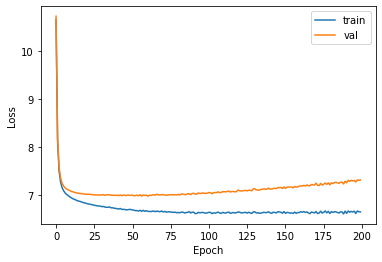

In [12]:
trainer.plot()

In [13]:
num_show = 20

y_test = model.predict(x_test)

synop = pd.read_csv('../clean_data/synopsis.csv')

for idx, mal_id in enumerate(id_test[:num_show]):
    pred = genre_cols[y_test[idx]>0.5]
    true = genre_cols[t_test[idx]==1]
    syn = synop.loc[synop.MAL_ID==mal_id, 'Synopsis'].item()

    print('synopsis:', syn)
    print('predict:', pred)
    print('answer: ', true)
    print()

synopsis: magic real performed true expert magic ability audience son famous stage arts frequently lives flashy hidden passage secret father death white outfit kid thief father outfit searches grant organization responsible father death hot magic kid thief night signature card gun sets steal precious truth father death rumored
predict: ['Action' 'Adventure']
answer:  ['Adventure' 'Comedy' 'Romance' 'Shounen']

synopsis: war pockets struggle survive technologies ignorance artificially machines pursue protect destroy terrible evil threatening bring
predict: ['Adventure']
answer:  ['Action' 'Adventure' 'Fantasy' 'Mecha' 'Sci-Fi']

synopsis: people prefer game girl lucky memories life fortune games play character game main extensive knowledge game takes escape chains easy feat cautious set death flags speed impending avoid change affect lives
predict: ['Fantasy']
answer:  ['Comedy' 'Drama' 'Fantasy' 'Romance' 'School']

synopsis: country girl prestigious school likes rich arrogant boy like